In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the Excel file
file_path = '/content/Wind Speed Data_CY 2011 edited (1).xlsx'
data = pd.read_excel(file_path)

# Clean the data
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ['Timestamp', 'Speed at 75mtr']
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp'])
data_cleaned.set_index('Timestamp', inplace=True)
data_cleaned['Speed at 75mtr'] = pd.to_numeric(data_cleaned['Speed at 75mtr'], errors='coerce')

# Extract January and February data
january_data = data_cleaned['2011-01-01':'2011-01-31'].dropna()
february_data = data_cleaned['2011-02-01':'2011-02-28'].dropna()

# Combine January and February data for scaling
combined_data = pd.concat([january_data, february_data])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data)

# Split the data back into training and testing sets
train_data = scaled_data[:len(january_data)]
test_data = scaled_data[len(january_data):]


In [3]:
# Function to create sequences of data
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 60  # e.g., using past 60 time steps to predict the next step
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
111/111 [==============================] - 13s 70ms/step - loss: 0.0124 - val_loss: 0.0061
Epoch 2/20
111/111 [==============================] - 5s 47ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 3/20
111/111 [==============================] - 6s 56ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 4/20
111/111 [==============================] - 6s 50ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 5/20
111/111 [==============================] - 5s 48ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/20
111/111 [==============================] - 7s 59ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/20
111/111 [==============================] - 7s 63ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/20
111/111 [==============================] - 7s 60ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 9/20
111/111 [==============================] - 5s 48ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/20
111/111 [==============================] - 10s 89ms/step - loss: 0.0018 - val_

In [5]:
# Make predictions
predicted_speed = model.predict(X_test)

# Inverse transform the predictions to get actual values
predicted_speed = scaler.inverse_transform(predicted_speed)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


125/125 [==============================] - 3s 16ms/step


Mean Squared Error: 0.4082311586122041


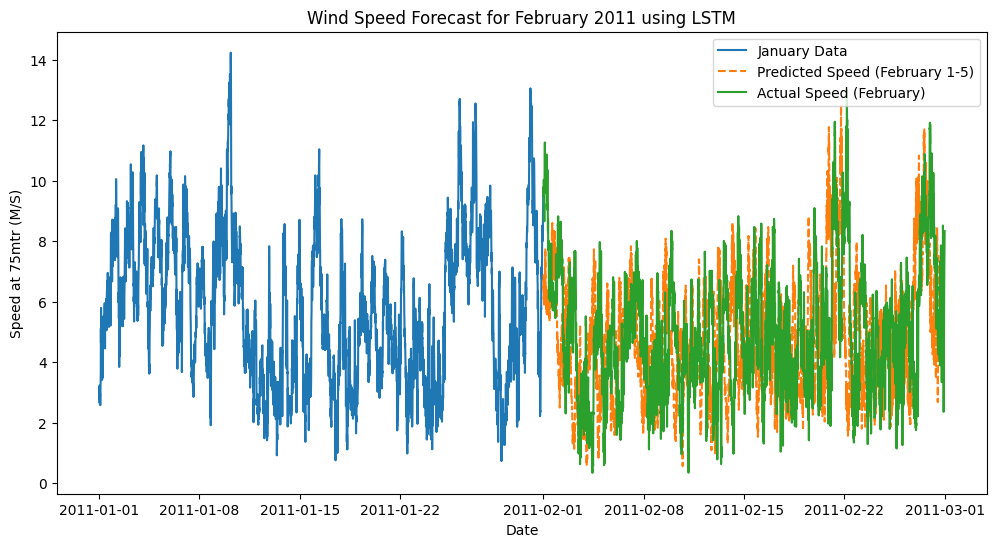

In [8]:
# Evaluate the model
mse = mean_squared_error(y_test_actual, predicted_speed)
print('Mean Squared Error:', mse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(january_data.index, january_data['Speed at 75mtr'], label='January Data')
plt.plot(february_data.index[:len(predicted_speed)], predicted_speed, label='Predicted Speed (February 1-5)', linestyle='--')
plt.plot(february_data.index, february_data['Speed at 75mtr'], label='Actual Speed (February)', linestyle='-')
plt.title('Wind Speed Forecast for February 2011 using LSTM')
plt.xlabel('Date')
plt.ylabel('Speed at 75mtr (M/S)')
plt.legend()
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [1]:
!pip install tensorflow
